# 분류(Classification)

https://hiiionion.notion.site/ADP-9ccf8ab1d3ac4c2ca967b8c726488590#6856c3c4b4ad43dda395ef7f5b79d6ee

#### 암 환자를 진단할 때 TPR이 중요하지만, 그렇다고 Recall만을 기준으로 판단하는 것에는 무리가 있다. 

- Recall만을 단일 판단 기준으로 한다는 것은, 암에 걸린 환자를 오진할 수 있는 리스크가 있기 때문에
- 암이 의심되는 환자든 일반적인 환자든 모두 암에 걸렸다고 진단하겠다고 하는 것과 동일하다. 
- 이 경우, Precision이 형편없게 떨어질 가능성이 높다 
- 즉, 정밀도와 재현율은 한 지표의 값이 높아지면 다른 지표의 값이 낮아질 가능성이 높은 관계를 지니고 있다. 
- 따라서, TPR이 중요한 태스크에서도 Recall만을 보는 것이 아니라, Recall과 Precision의 조화평균인 F1 Score를 사용하는 것이 바람직하다.

## 1.Introduction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer

In [3]:
# 데이터 셋 로드
cancer = load_breast_cancer()

In [4]:
print(cancer.DESCR[27:3135])


Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radius, field
        10 is Rad

## 2.EDA

In [7]:
# 데이터 프레임 만들기
dfx = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
dfy = pd.DataFrame(cancer['target'], columns=["target"])
df = pd.concat([dfx, dfy], axis=1)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [8]:
df.info() # 총 30개의 속성과 malignant(악성), benign(양성)의 타겟값을 가지고 있다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [10]:
# Target의 Category가 2개로 Binary Classification임을 알 수 있다. 
cancer.target_names 

array(['malignant', 'benign'], dtype='<U9')

In [11]:
dfy['target'].value_counts() # 양성 357개, 악성 212개

1    357
0    212
Name: target, dtype: int64

In [12]:
df.describe() # 변수별로 단위가 다르므로 스케일링 해줄 필요

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


각 변수별 분포를 보고 양성과 악성이 어떤 특징을 보이는 지 살펴본다.
여러 변수의 분포를 시각화하기위해 데이터를 표준화 해준다.



In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dfx) # 평균과 표준편차를 계산한다

features_scaled = scaler.transform(dfx) # 정규화 
features_scaled = pd.DataFrame(data=features_scaled,
                               columns=dfx.columns)

df_scaled = pd.concat([features_scaled, df['target']], axis=1)
df_scaled.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,0
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,0
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,0
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,0
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,0


In [14]:
df_scaled_melt = pd.melt(df_scaled, id_vars='target',
                         var_name='features', value_name='value') 
df_scaled_melt.head(3)

,target,features,value
0,0,mean radius,1.097064
1,0,mean radius,1.829821
2,0,mean radius,1.579888


In [15]:
def violin_plot(features, name):
    """
    This function creates violin plots of features given in the argument.
    """
    # Create query
    query = ''
    for x in features:
        query += "features == '" + str(x) + "' or "
    query = query[0:-4]

    # Create data for visualization
    data = df_scaled_melt.query(query)

    # Plot figure
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='features',
                   y='value',
                   hue='target',
                   data=data,
                   split=True,
                   inner="quart")
    plt.xticks(rotation=45)
    plt.title(name)
    plt.xlabel("Features")
    plt.ylabel("Standardize Value")


def swarm_plot(features, name):
    """
    This function creates swarm plots of features given in the argument.
    """
    # Create query
    query = ''
    for x in features:
        query += "features == '" + str(x) + "' or "
    query = query[0:-4]

    # Create data for visualization
    data = df_scaled_melt.query(query)

    # Plot figure
    plt.figure(figsize=(12, 6))
    sns.swarmplot(x='features', y='value', hue='target', data=data)
    plt.xticks(rotation=45)
    plt.title(name)
    plt.xlabel("Features")
    plt.ylabel("Standardize Value")


def box_plot(features, name):
    """
    This function creates box plots of features given in the argument.
    """
    # Create query
    query = ''
    for x in features:
        query += "features == '" + str(x) + "' or "
    query = query[0:-4]

    # Create data for visualization
    data = df_scaled_melt.query(query)

    # Plot figure
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='features', y='value', hue='target', data=data)
    plt.xticks(rotation=45)
    plt.title(name)
    plt.xlabel("Features")
    plt.ylabel("Standardize Value")

- violin plot은 여러 변수의 분포를 비교하는 데 매우 효율적이다.
- 분류는 swarm plot에서 명확하게 확인할 수 있다.
- Box Plot은 중위수를 비교하고 특이치를 제거하는 데 유용하다.

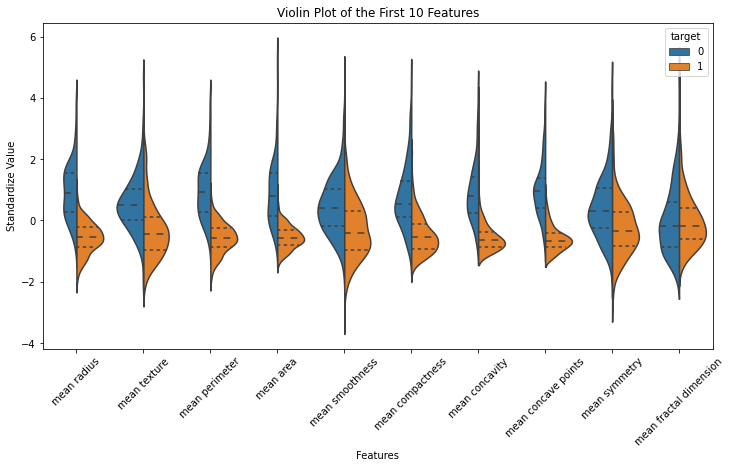

In [17]:
violin_plot(df.columns[0:10], "Violin Plot of the First 10 Features")

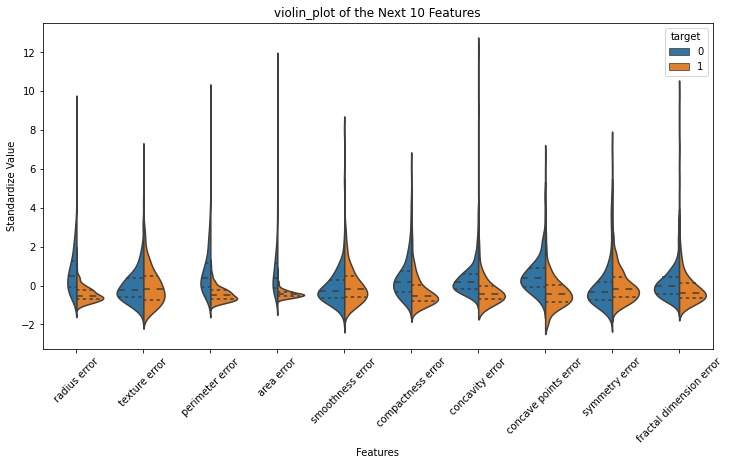

In [18]:
violin_plot(df.columns[10:20], "violin_plot of the Next 10 Features")

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 72.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 68.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 73.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 75.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 69.8% of the points cannot be placed; y

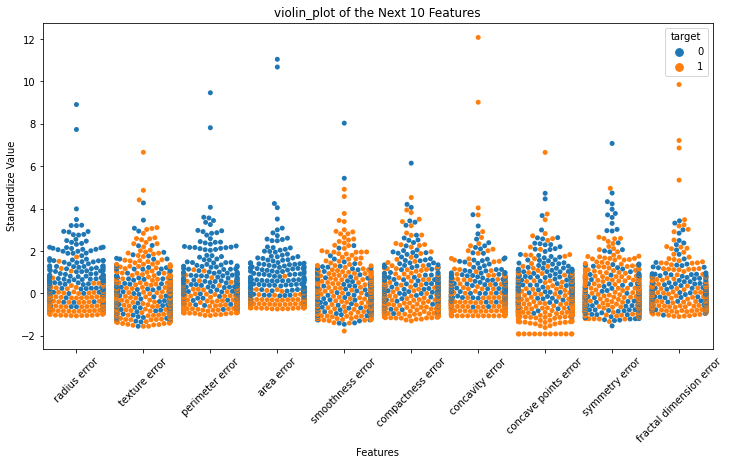

In [19]:
swarm_plot(df.columns[10:20], "violin_plot of the Next 10 Features")

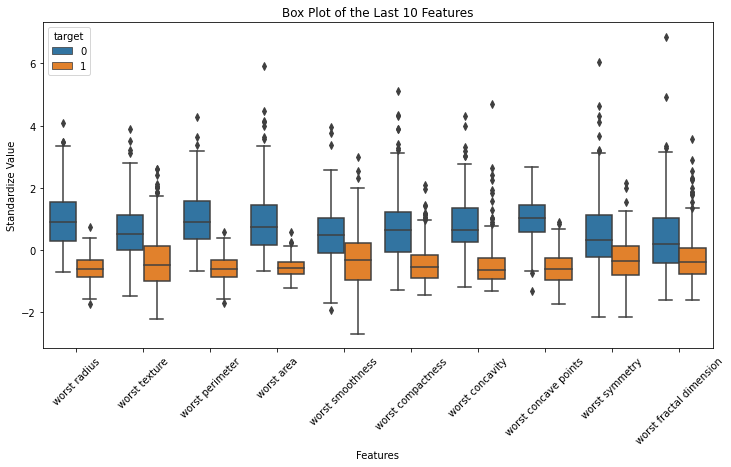

In [20]:
box_plot(df.columns[20:30], "Box Plot of the Last 10 Features")

- 일부 변수의 중앙값은 양성과 악성일때 차이가 있다. 이런 점은 분류시에 유용한 특징이다.
:` mean radius`, `mean area, mean concave points, worst radius, worst perimeter, worst area, worst concave points `
- 양성과 악성이 서로 분포가 비슷한 경우에는 데이터 분류를 어렵게 만든다.
: `mean smoothness, mean symmetry, mean fractual dimension, smoothness error`
- 일부 변수은 분포가 유사해 서로 높은 상관관계가 있을 수 있다.
: `mean perimeter` vs. `mean area`, `mean concavity` vs. `mean concave points`, `worst symmetry` vs. `worst fractal dimension`.

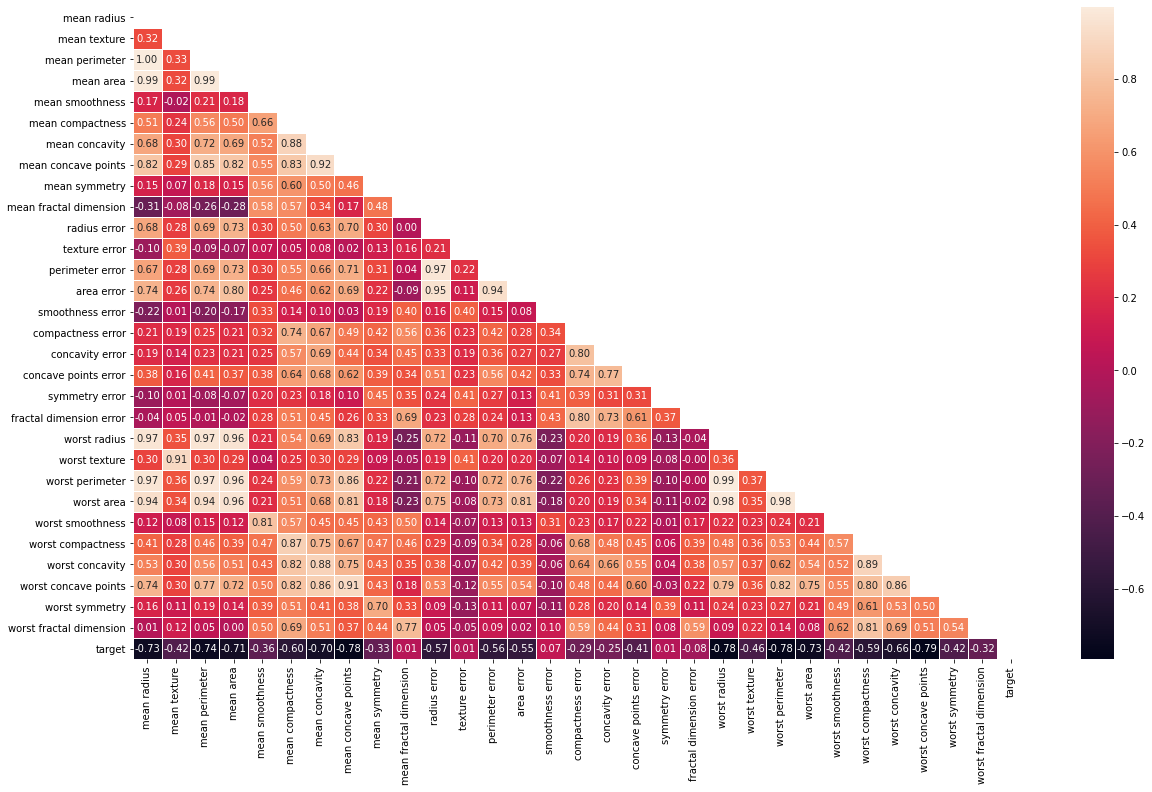

In [21]:
# heatmap 

plt.figure(figsize = (20, 12))

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

sns.heatmap(corr, mask = mask, linewidths = 1, annot = True, fmt = ".2f")
plt.show()

다중 공선성을 유발하는 매우 높은 상관 관계가 있는 열이 많이 있으므로 상관 관계가 높은 변수를제거해야 한다.

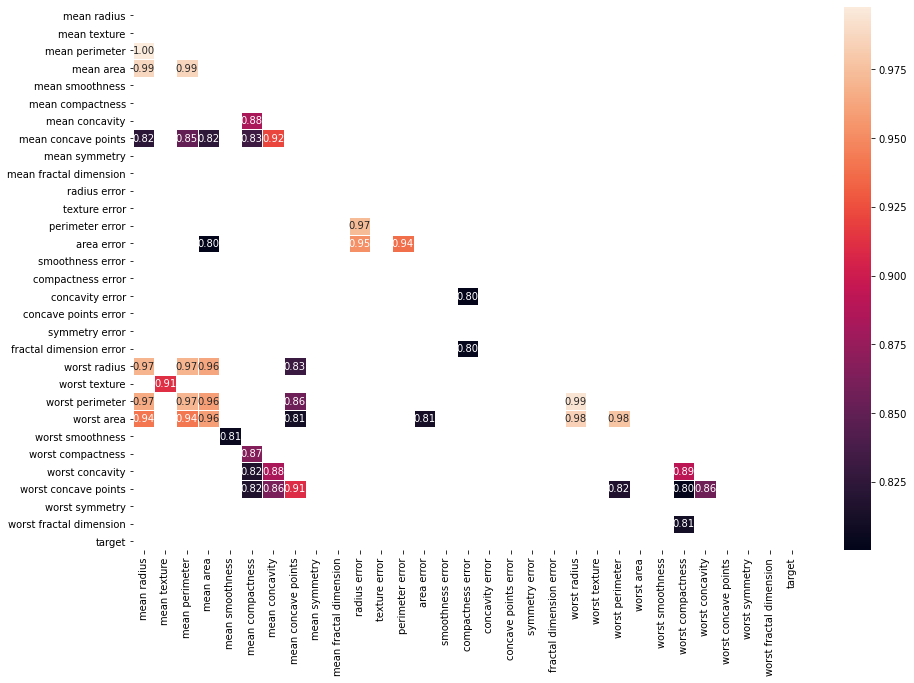

In [22]:
# 상관관계가 0.8보다 큰 변수
plt.figure(figsize=(15, 10))
sns.heatmap(corr[corr > 0.8], mask = mask, linewidths = 1, annot = True, fmt = ".2f")
plt.show()

## 3.Modeling

### Feature Selection
단일 변수 선택법 (sklearn.feature_selection.SelectKBest) 을 사용하여 k개의 가장 성능이 좋은 변수만 사용한다.

In [23]:
from sklearn.feature_selection import SelectKBest, chi2

# sklearn.feature_selection.SelectKBest(score_func=<function f_classif>, *, k=10)
feature_selection = SelectKBest(chi2, k=5) # 카이제곱검정 기준 #상관관계가 높은 변수를 선택해준다 
feature_selection.fit(dfx, dfy)
selected_features = dfx.columns[feature_selection.get_support()]
print("선택된 변수 5개: ", list(selected_features))

선택된 변수 5개:  ['mean perimeter', 'mean area', 'area error', 'worst perimeter', 'worst area']


In [26]:
# sklearn.feature_selection.SelectKBest.get_support( ) 출력 확인
# Get a mask, or integer index, of the features selected.
feature_selection.get_support()

array([False, False,  True,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False])

In [27]:
X = pd.DataFrame(feature_selection.transform(dfx),
                 columns=selected_features)
X.head()

,mean perimeter,mean area,area error,worst perimeter,worst area
0,122.80,1001.0,153.40,184.60,2019.0
1,132.90,1326.0,74.08,158.80,1956.0
2,130.00,1203.0,94.03,152.50,1709.0
3,77.58,386.1,27.23,98.87,567.7
4,135.10,1297.0,94.44,152.20,1575.0


In [29]:
X.dtypes

mean perimeter     float64
mean area          float64
area error         float64
worst perimeter    float64
worst area         float64
dtype: object

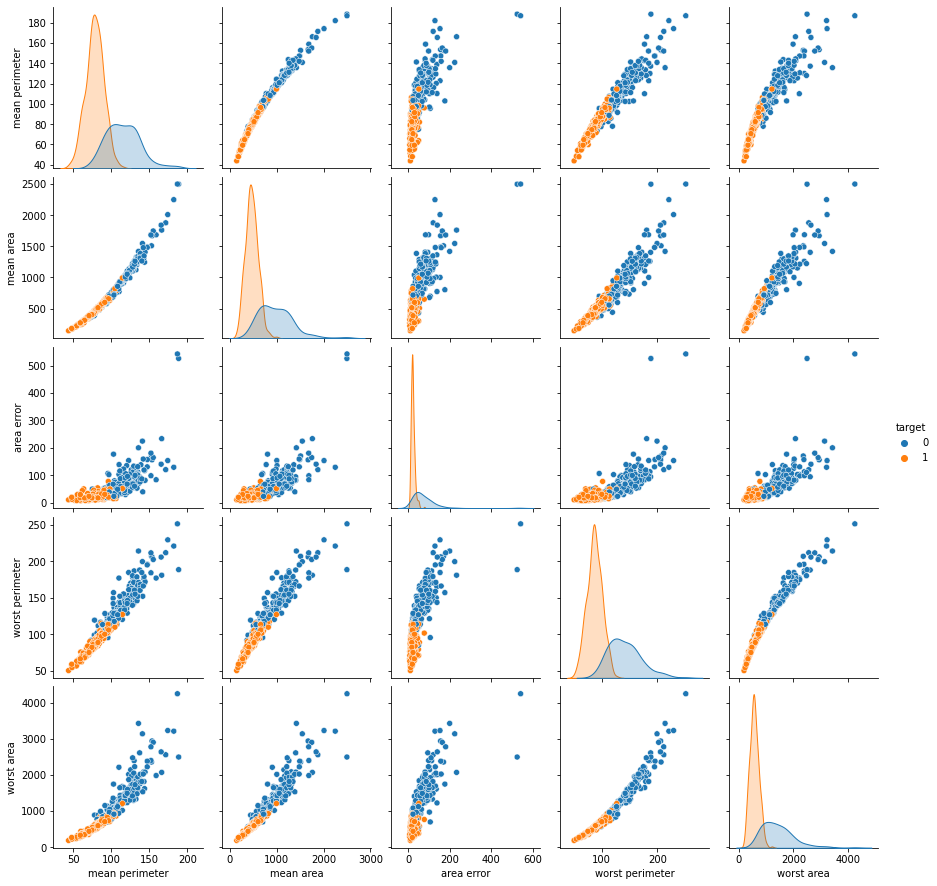

In [28]:
# https://www.youtube.com/watch?v=uCgvlfIo9fg

# hue : Variable in data to map plot aspects to different colors.
sns.pairplot(pd.concat([X, df['target']], axis=1), hue='target') # . 각 column별 데이터에 대한 상관관계나 분류적 특성 확인

In [30]:
from sklearn.model_selection import train_test_split
y = dfy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

### Logistic Regression Classifier
- scikit-learn에서 기본 로지스틱 회귀가 정확히 로지스틱 회귀가 아니라 페널티가 적용된 로지스틱 회귀(기본적으로 L2 페널티가 있는 능선 회귀)

In [31]:
# fitting data to model

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [95]:
for col_name, coef in zip(X_train.columns, log_reg.coef_[0]):
    print(col_name,"계수의 Oddds Ratio:", np.exp(coef))

mean perimeter 계수의 Oddds Ratio: 0.8129280694991815
mean area 계수의 Oddds Ratio: 1.0327344683402175
area error 계수의 Oddds Ratio: 0.9443272570957428
worst perimeter 계수의 Oddds Ratio: 0.8653175740850905
worst area 계수의 Oddds Ratio: 0.9884232264500394


In [32]:
# model predictions

y_pred = log_reg.predict(X_test) # .predict( ) : 클래스를 예측하고 싶을 때 

In [50]:
proba_pred = log_reg.predict_proba(X_test) # .predict_proba( ) : 각 Class에 대한 확률을 예측하고 싶을 때
proba_pred[:5]

array([[2.58542312e-01, 7.41457688e-01],
       [9.99999535e-01, 4.64949449e-07],
       [9.95448385e-01, 4.55161531e-03],
       [1.49047931e-02, 9.85095207e-01],
       [4.30309998e-03, 9.95696900e-01]])

In [51]:
probaLog_pred = log_reg.predict_log_proba(X_test) # .predict_log_proba( ) : 확률의 Log값을 구하고 싶을 때  
probaLog_pred[:5]

array([[-1.35269592e+00, -2.99137181e-01],
       [-4.64949558e-07, -1.45813371e+01],
       [-4.56200545e-03, -5.39227310e+00],
       [-4.20607243e+00, -1.50169857e-02],
       [-5.44841959e+00, -4.31238496e-03]])

In [33]:
# accuracy score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

log_reg_acc = accuracy_score(y_test, y_pred)
print(log_reg_acc) # 테스트 데이터 정확도

0.9707602339181286


In [34]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm) # 숫자로 정렬, [TN,FP,FN,TP]

[[ 61   2]
 [  3 105]]


Accuracy는 높지만, Data의 불균형을 찾아볼 수 있다

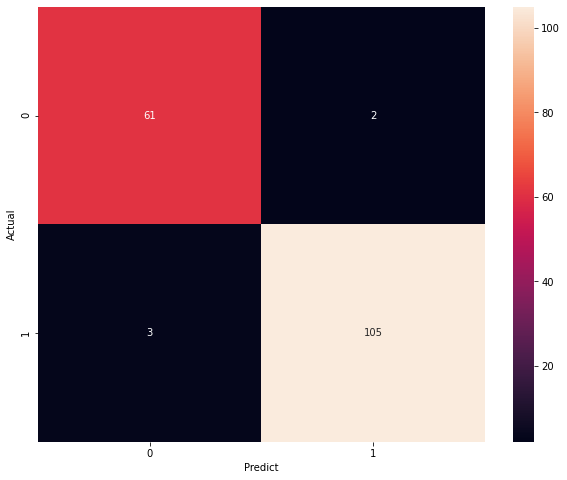

In [35]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [36]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        63
           1       0.98      0.97      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



In [37]:
# Precision
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

0.9813084112149533

In [38]:
# Sensitivity
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.9722222222222222

In [39]:
# F1 Score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.9767441860465117

AUC: 0.9702380952380952


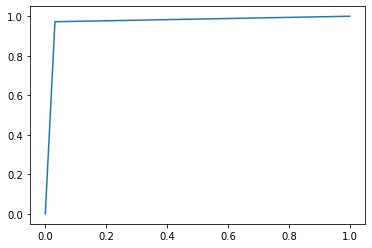

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test,y_pred, pos_label = 1)# positive class label

# thresholds : Decreasing score values

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = roc_auc_score(y_test,y_pred)
print("AUC:",auc)

ROC Curve가 (0,1)에 가까운 것으로 나타나며, 이를 통해 Logistic Classifier의 높은 성능을 확인할 수 있다. 

In [41]:
type(thresholds)

numpy.ndarray

In [42]:
thresholds.shape

(3,)

In [43]:
thresholds[0]

2

In [44]:
thresholds[1]

1

In [45]:
thresholds[2]

0

###### Threshold 비교

In [97]:
proba_pred[:,1][:5]

array([7.41457688e-01, 4.64949449e-07, 4.55161531e-03, 9.85095207e-01,
       9.95696900e-01])

In [77]:
max(proba_pred[:,1])

0.9999886939456172

In [78]:
min(proba_pred[:,1])

1.2647440898063335e-17

In [120]:
res = []
for thr in thresholds:
    y_pred = proba_pred[:,1] > thr
    tp = len(y_test[(y_test['target'] == 1)&(y_pred ==1)])  
    tn = len(y_test[(y_test['target'] == 0)&(y_pred ==0)])  
    fp = len(y_test[(y_test['target'] == 0)&(y_pred ==1)])  
    fn = len(y_test[(y_test['target'] == 1)&(y_pred ==0)]) 
    res.append((tp,tn,fp,fn,thr))

In [122]:
res

[(0, 63, 0, 108, 2), (0, 63, 0, 108, 1), (108, 0, 63, 0, 0)]

In [123]:
cm = pd.DataFrame(res)
'tp,tn,fp,fn,thr'.split(',')
cm.columns = ['tp', 'tn', 'fp', 'fn', 'thr']
cm['tpr'] = cm['tp'] / (cm['tp'] + cm['fn'])
cm['fpr'] = cm['fp'] / (cm['fp'] + cm['tn'])

In [124]:
cm

,tp,tn,fp,fn,thr,tpr,fpr
0,0,63,0,108,2,0.0,0.0
1,0,63,0,108,1,0.0,0.0
2,108,0,63,0,0,1.0,1.0


<AxesSubplot:xlabel='fpr'>

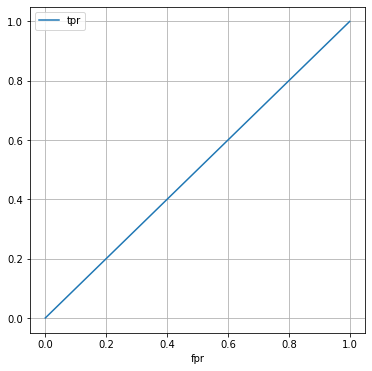

In [125]:
cm.plot(x='fpr',y='tpr',grid=True,figsize=(6,6))

In [126]:
from matplotlib import pyplot as plt

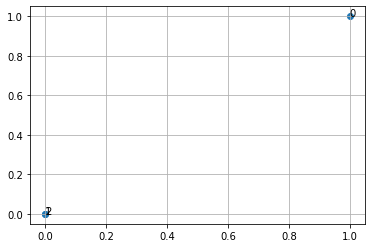

In [127]:
fig, ax = plt.subplots()
ax.scatter(cm['fpr'],cm['tpr'])

for i, txt in enumerate(cm['thr']):
    ax.annotate(round(txt,2), (cm['fpr'][i], cm['tpr'][i]))

plt.grid()

In [128]:
cm['tpr-fpr'] = cm['tpr'] - cm['fpr']

In [129]:
cm.sort_values('tpr-fpr',ascending=False)

,tp,tn,fp,fn,thr,tpr,fpr,tpr-fpr
0,0,63,0,108,2,0.0,0.0,0.0
1,0,63,0,108,1,0.0,0.0,0.0
2,108,0,63,0,0,1.0,1.0,0.0


In [130]:
cm['profit'] = cm['tp'] * 10 - cm['fp']*100

In [131]:
cm.sort_values('profit',ascending=False)

,tp,tn,fp,fn,thr,tpr,fpr,tpr-fpr,profit
0,0,63,0,108,2,0.0,0.0,0.0,0
1,0,63,0,108,1,0.0,0.0,0.0,0
2,108,0,63,0,0,1.0,1.0,0.0,-5220


###### probaLog_pred

In [139]:
probaLog_pred.shape

(171, 2)

In [135]:
probaLog_pred[:5]

array([[-1.35269592e+00, -2.99137181e-01],
       [-4.64949558e-07, -1.45813371e+01],
       [-4.56200545e-03, -5.39227310e+00],
       [-4.20607243e+00, -1.50169857e-02],
       [-5.44841959e+00, -4.31238496e-03]])

In [141]:
max(probaLog_pred[:,1])

-1.1306118296734882e-05

In [140]:
min(probaLog_pred[:,1])

-38.90907677973316

??? roc_curve가 반환하는 Threshold [0,1,2]는 무엇을 의미하는가? 

### K Neighbors Classifier (KNN)

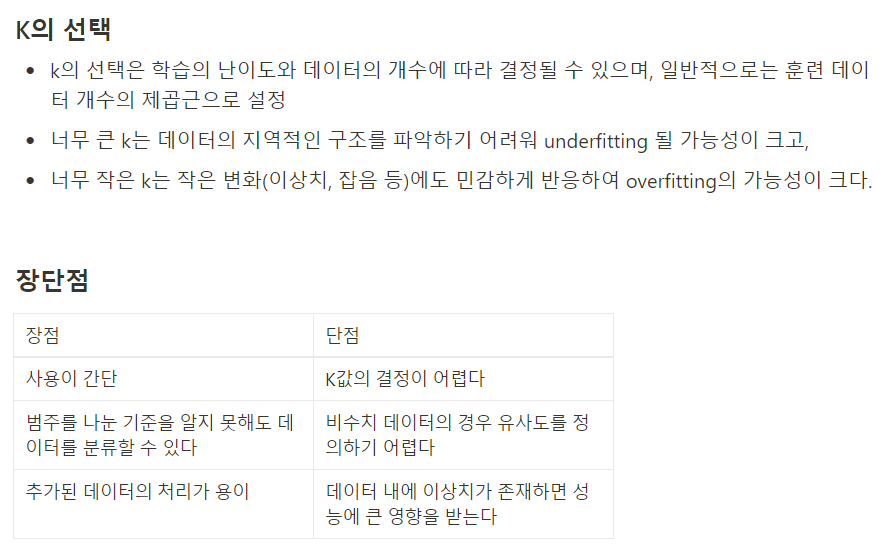

In [142]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [143]:
# model predictions

y_pred = knn.predict(X_test)

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [144]:
# accuracy score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(accuracy_score(y_train, knn.predict(X_train)))

knn_acc = accuracy_score(y_test, y_pred)
print(knn_acc)

0.9271356783919598
0.9532163742690059


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [145]:
# confusion matrix

print(confusion_matrix(y_test, y_pred))

[[ 58   5]
 [  3 105]]


In [146]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94        63
           1       0.95      0.97      0.96       108

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



### Support Vector Classifier (SVC)

In [147]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC()
parameters = {                                    # C와 gamma Parameter를 통해 decision boundary를 조절
    'gamma' : [0.0001, 0.001, 0.01, 0.1],         # gamma가 증가할 수록 결정결계를 빠르게 변화하게 하여 더 복잡한 모델
    'C' : [0.01, 0.05, 0.5, 0.1, 1, 10, 15, 20]   # C를 증가시키면 하드마진,overfitting
}

grid_search = GridSearchCV(svc, parameters)
grid_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.05, 0.5, 0.1, 1, 10, 15, 20],
                         'gamma': [0.0001, 0.001, 0.01, 0.1]})

In [148]:
#C# best parameters

grid_search.best_params_

{'C': 0.5, 'gamma': 0.0001}

In [149]:
svc = SVC(C = 0.5, gamma = 0.0001)
svc.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=0.5, gamma=0.0001)

In [150]:
# model predictions 

y_pred = svc.predict(X_test)

In [151]:
# accuracy score

print(accuracy_score(y_train, svc.predict(X_train)))

svc_acc = accuracy_score(y_test, svc.predict(X_test))
print(svc_acc)

0.9371859296482412
0.9649122807017544


In [152]:
# confusion matrix

cf_matrix=confusion_matrix(y_test, y_pred)

In [153]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        63
           1       0.96      0.99      0.97       108

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171



### Decision Tree Classifier

In [154]:
from sklearn.tree import DecisionTreeClassifier

dt_clf =  DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [155]:
y_pred = dt_clf.predict(X_test)

In [156]:
# accuracy score

print(accuracy_score(y_train, dt_clf.predict(X_train)))

dt_clf_acc = accuracy_score(y_test, y_pred)
print(dt_clf_acc)

1.0
0.9239766081871345


In [157]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90        63
           1       0.94      0.94      0.94       108

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.92      0.92      0.92       171



In [158]:
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 KB 6.7 MB/s eta 0:00:00


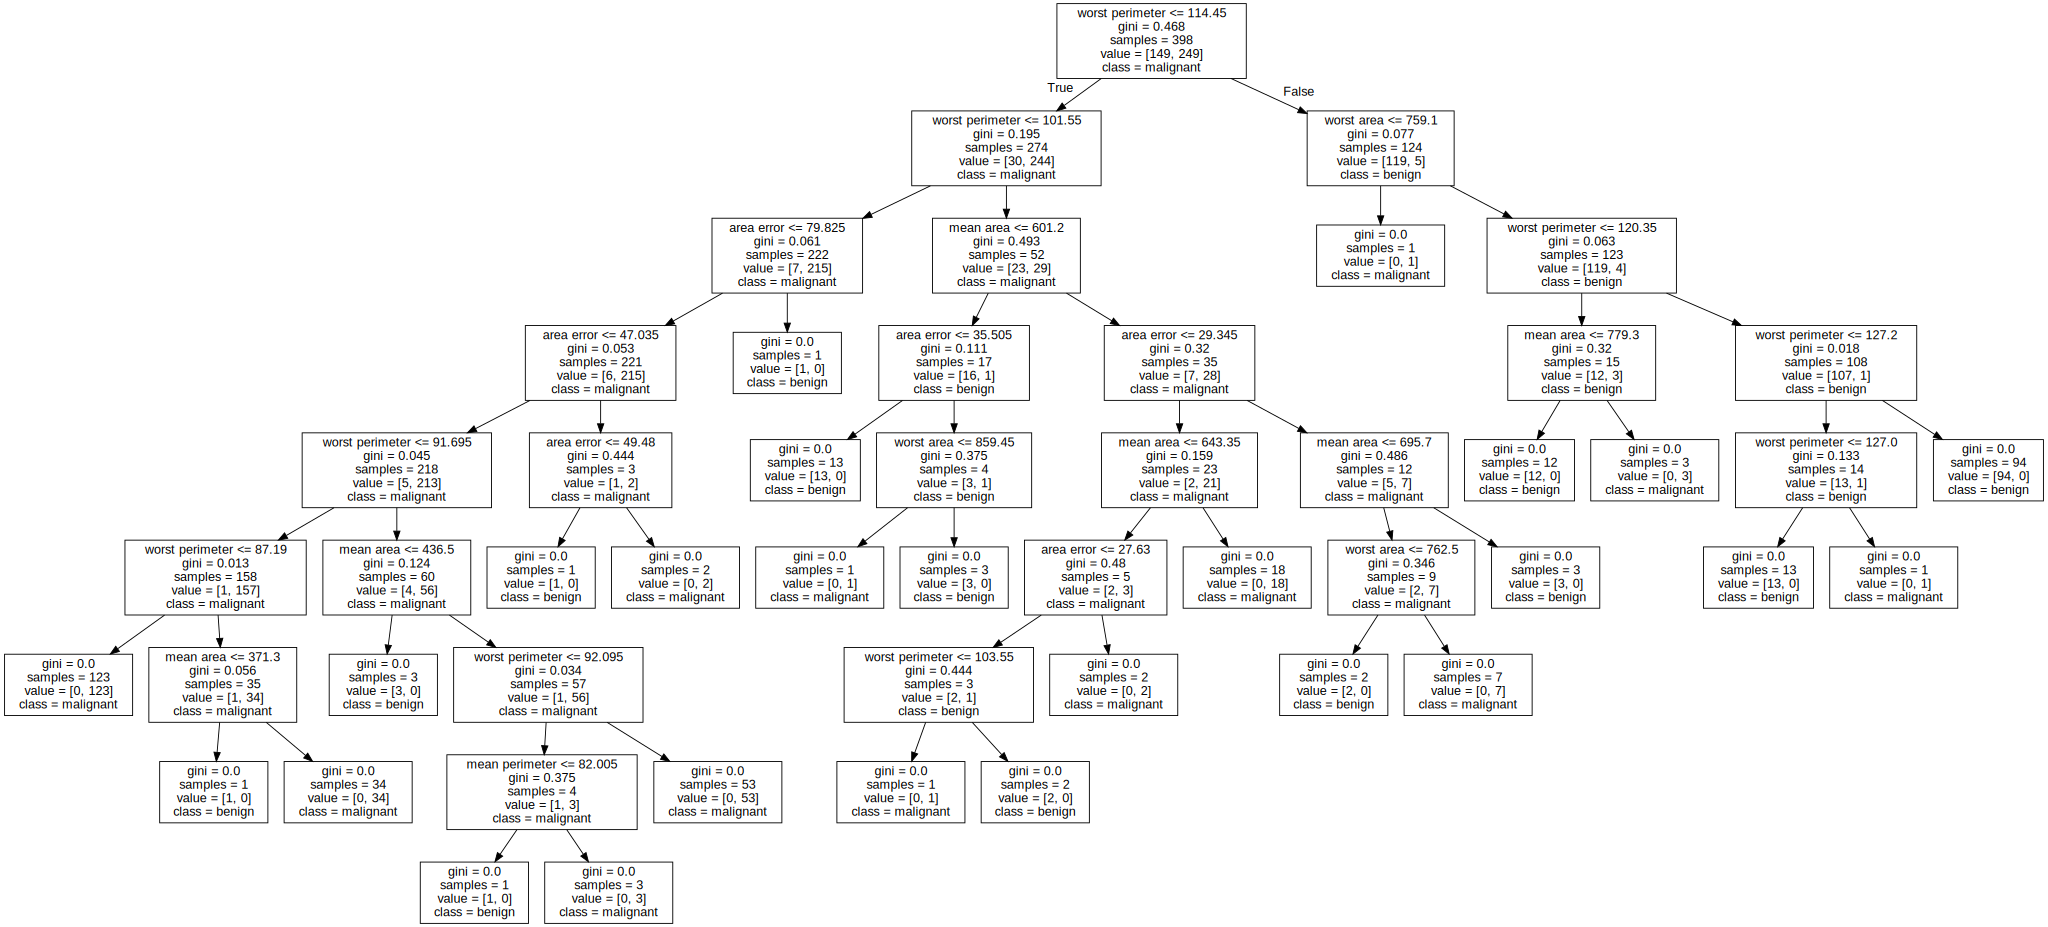

In [159]:
# 의사결정나무 분류 시각화
import graphviz
from sklearn.tree import export_graphviz

tree_dot = export_graphviz(dt_clf, out_file=None, feature_names=X.columns, class_names=np.unique(cancer['target_names']))
tree = graphviz.Source(tree_dot)
tree # gini 계수가 높을 수록 엔트로피가 크다.(복잡함)

In [160]:
# 가지 치기 (pruning): 과적합 방지를 위해 가지치기를 진행한다.
dt_clf2 = DecisionTreeClassifier(max_depth=2) # 수동으로 max_depth 설정
dt_clf2.fit(X_train, y_train)
y_pred = dt_clf2.predict(X_test)

In [161]:
# accuracy score

print(accuracy_score(y_train, dt_clf2.predict(X_train)))

dt_clf2_acc = accuracy_score(y_test, y_pred)
print(dt_clf2_acc)

0.914572864321608
0.935672514619883


In [162]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.83      0.90        63
           1       0.91      1.00      0.95       108

    accuracy                           0.94       171
   macro avg       0.95      0.91      0.93       171
weighted avg       0.94      0.94      0.93       171



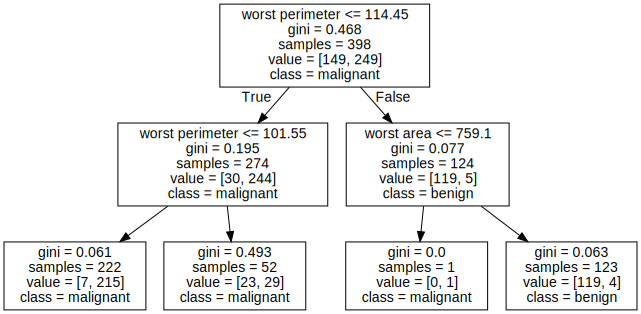

In [163]:
tree2_dot = export_graphviz(dt_clf2, out_file=None, feature_names=X.columns, class_names=np.unique(cancer['target_names']))
tree2 = graphviz.Source(tree2_dot)
tree2

### Naive Bayse Classifier
scikit-learn에 구현된 나이브 베이즈 분류기는 GaussianNB, BernoulliNB, MultinomialNB 세 가지 
- GaussianNB는 연속적인 어떤 데이터에도 적용 가능
- BernoulliNB는 이진 데이터에 적용
- MultinomialNB는 카운트 데이터(예를 들면 문장에 나타난 단어의 횟수)에 적용
- BernoulliNB, MultinomialNB는 주로 텍스트 데이터를 분류할 때 사용

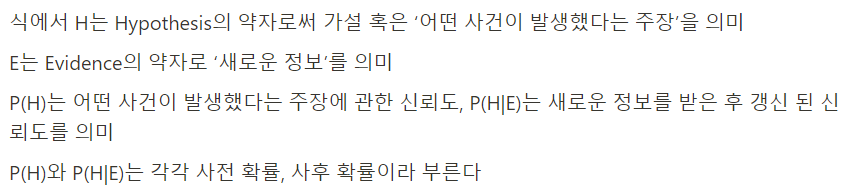

In [164]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB # 베르누이 나이브 베이즈 성능이 낮아서 가우시간으로 진행

nb = GaussianNB()
nb.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [165]:
y_pred = nb.predict(X_test)

In [166]:
print(accuracy_score(y_train, nb.predict(X_train)))

nb_acc = accuracy_score(y_test, nb.predict(X_test))
print(nb_acc)

0.8994974874371859
0.9532163742690059


In [167]:
# confusion matrix

print(confusion_matrix(y_test, y_pred))

[[ 56   7]
 [  1 107]]


In [168]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93        63
           1       0.94      0.99      0.96       108

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171



In [169]:
# 모델 정확도 비교
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'SVC', 'Decison Tree Classifier', 
            'Naive Bayes Classifier'],
    'Score': [log_reg_acc, knn_acc, svc_acc,dt_clf_acc, nb_acc]
})

models.sort_values(by = 'Score', ascending = False)

,Model,Score
0,Logistic Regression,0.970760
2,SVC,0.964912
1,KNN,0.953216
4,Naive Bayes Classifier,0.953216
3,Decison Tree Classifier,0.923977
